# 배경
* 스마트 공장은 공정 데이터에서 인사이트를 발굴하고 해석하여 추세를 예측하고, 스마트 제조 워크플로와 자동화된 프로세스를 구현합니다.

* 품질 편차를 최소화해 생산 경제성과 안정성을 확보할 수 있도록 생산된 제품이 적정 기준을 충족하는지 판단하고 분류하는 AI 모델을 개발해 주세요.



# 설명
* 실제 스마트 공장 데이터를 기반으로 제품의 품질 상태를 분류하는 AI 모델을 개발하세요.

# Data info.
* Y_Class : 제품 품질 상태(Target) 
 * 0 : 적정 기준 미달 (부적합)
 * 1 : 적합
 * 2 : 적정 기준 초과 (부적합)
* Y_Quality : 제품 품질 관련 정량적 수치
* TIMESTAMP : 제품이 공정에 들어간 시각
* LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
* PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
* X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수

## Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import os
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정

## Data load

In [3]:
train_df = pd.read_csv('Dacon_data/train.csv')
test_df = pd.read_csv('Dacon_data/test.csv')

In [4]:
train_df.head()

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN


In [5]:
test_df.head()

,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TEST_000,2022-09-09 2:01,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TEST_001,2022-09-09 2:09,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TEST_002,2022-09-09 8:42,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TEST_003,2022-09-09 10:56,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEST_004,2022-09-09 11:04,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
process = train_df["LINE"].value_counts() # 어떤 공정들이 있는지
process

T100304    175
T100306    174
T050304     78
T010306     70
T010305     59
T050307     42
Name: LINE, dtype: int64

In [7]:
good = train_df[train_df['Y_Class'] == 1]
good

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN
6,TRAIN_006,1,0.533665,2022-06-13 6:03,T050304,A_31,NaN,NaN,NaN,NaN,...,32.50,41.42,38.36,30.83,76.93,NaN,NaN,NaN,NaN,NaN
8,TRAIN_008,1,0.531821,2022-06-13 6:19,T050304,A_31,NaN,NaN,NaN,NaN,...,42.25,43.17,55.60,33.26,78.50,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,TRAIN_591,1,0.529308,2022-09-07 1:09,T100306,T_31,1.0,87.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
592,TRAIN_592,1,0.528349,2022-09-08 14:22,T100304,T_31,2.0,98.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
593,TRAIN_593,1,0.526546,2022-09-08 14:30,T100306,T_31,2.0,95.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
596,TRAIN_596,1,0.531375,2022-09-08 14:38,T100304,O_31,40.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
len(good) # 598개의 제품중 407개 양호 -> 191개 불량

407

In [9]:
good_process_count = good["LINE"].value_counts()
good_process_count # 전체 데이터의 공정 추이와 비교해보았을때 각 공정들이 -30-40, 즉 각 공정에서 약 30개의 제품들을 제외하고 양호하다. 

T100306    145
T100304    144
T050304     37
T010306     37
T010305     35
T050307      9
Name: LINE, dtype: int64

<AxesSubplot:xlabel='LINE', ylabel='count'>

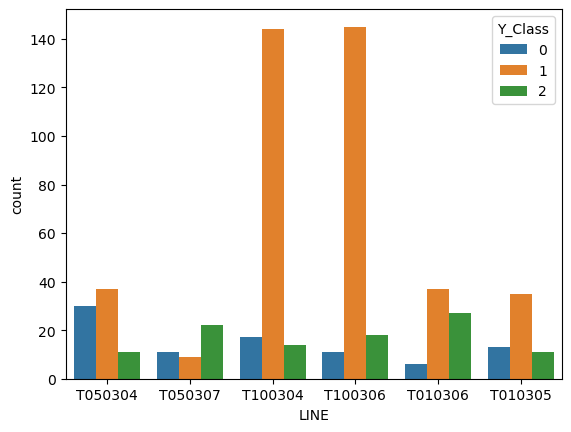

In [10]:
sns.countplot(data=train_df, x='LINE', hue='Y_Class')
# T100304, T100306의 공정이 적합한 제품 품질을 보임

In [11]:
code = train_df["PRODUCT_CODE"].value_counts()
code

T_31    343
A_31    249
O_31      6
Name: PRODUCT_CODE, dtype: int64

<AxesSubplot:xlabel='PRODUCT_CODE', ylabel='count'>

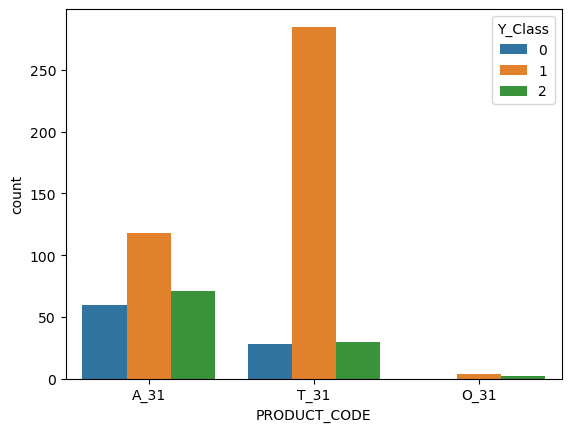

In [12]:
sns.countplot(data=train_df, x='PRODUCT_CODE', hue='Y_Class')
# 제품 코드별 품질 -> A_31에서 부적합률이 크다?

## Data Pre-processing

In [13]:
train_df = train_df.fillna(0)
train_df.head()

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,0.0,0.0,0.0,0.0,...,39.34,40.89,32.56,34.09,77.77,0.0,0.0,0.0,0.0,0.0
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,0.0,0.0,0.0,0.0,...,38.89,42.82,43.92,35.34,72.55,0.0,0.0,0.0,0.0,0.0
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,0.0,0.0,0.0,0.0,...,39.19,36.65,42.47,36.53,78.35,0.0,0.0,0.0,0.0,0.0
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,0.0,0.0,0.0,0.0,...,37.74,39.17,52.17,30.58,71.78,0.0,0.0,0.0,0.0,0.0
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,0.0,0.0,0.0,0.0,...,38.70,41.89,46.93,33.09,76.97,0.0,0.0,0.0,0.0,0.0


In [14]:
test_df = test_df.fillna(0)
test_df.head()

,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TEST_000,2022-09-09 2:01,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TEST_001,2022-09-09 2:09,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TEST_002,2022-09-09 8:42,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TEST_003,2022-09-09 10:56,T010305,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TEST_004,2022-09-09 11:04,T010306,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##  x와 y로 분리
feature 데이터는 x, label 데이터는 y에 저장.

In [15]:
# 예측해야 할 변수인 `Y_Class`를 제거하여 입력값인 y에 저장.
# x에는 X_000의 feature만 저장.
x = train_df.drop(columns = ['PRODUCT_ID', 'TIMESTAMP', 'Y_Class', 'Y_Quality'], axis = 1)
y = train_df['Y_Class']
x

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.34,40.89,32.56,34.09,77.77,0.0,0.0,0.0,0.0,0.0
1,T050307,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,38.89,42.82,43.92,35.34,72.55,0.0,0.0,0.0,0.0,0.0
2,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.19,36.65,42.47,36.53,78.35,0.0,0.0,0.0,0.0,0.0
3,T050307,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,37.74,39.17,52.17,30.58,71.78,0.0,0.0,0.0,0.0,0.0
4,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,38.70,41.89,46.93,33.09,76.97,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,50.0,10.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
594,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,49.47,53.07,50.89,55.10,66.49,1.0,0.0,0.0,0.0,0.0
595,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,1.0,0.0,0.0,0.0,0.0
596,T100304,O_31,40.0,94.0,0.0,45.0,11.0,0.0,45.0,10.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0


In [16]:
test_x = test_df.drop(columns = ['PRODUCT_ID', 'TIMESTAMP'], axis = 1)
test_x # 테스트 데이터

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,51.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,45.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,45.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,T010305,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,T010306,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,51.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306,T100304,T_31,2.0,96.0,0.0,45.0,11.0,0.0,45.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,50.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
308,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,51.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
from sklearn.preprocessing import StandardScaler

# 정규화를 위해 StandardScaler.
# 신경망 학습시 데이터셋의 값이 들쑥날쑥하거나, 매우 큰 경우에는 cost의 값이 발산하여 정상적인 학습이 이루어지지 않아
sc = StandardScaler()

# train_x에 있는 데이터에 맞춰 정규화를 진행. 
train_x = sc.fit_transform(x[x.columns[2:]]) # train은 fit_transform test는 transform
test_x = sc.transform(test_x[test_x.columns[2:]])
train_y = y
train_y

0      1
1      2
2      1
3      2
4      1
      ..
593    1
594    0
595    0
596    1
597    1
Name: Y_Class, Length: 598, dtype: int64

In [18]:
#mean()으로 평균을 구하고 var()로 분산.
x_train_sc = pd.DataFrame(data=train_x)
print("평균")
print(x_train_sc.mean())
print("분산")
print(x_train_sc.var())

평균
0      -1.232756e-16
1       1.338580e-16
2       0.000000e+00
3       1.234984e-15
4       4.323929e-16
            ...     
2870    6.486821e-16
2871    0.000000e+00
2872    0.000000e+00
2873    0.000000e+00
2874    0.000000e+00
Length: 2875, dtype: float64
분산
0       1.001675
1       1.001675
2       0.000000
3       1.001675
4       1.001675
          ...   
2870    1.001675
2871    0.000000
2872    0.000000
2873    0.000000
2874    0.000000
Length: 2875, dtype: float64


In [19]:
x_train_sc

,0,1,2,3,4,5,6,7,8,9,...,2865,2866,2867,2868,2869,2870,2871,2872,2873,2874
0,-0.302348,-1.181260,0.0,-1.183895,-1.180768,0.0,-1.172670,-1.183243,-1.102091,-1.183895,...,1.608668,1.574442,1.294833,1.297452,2.671373,-0.445418,0.0,0.0,0.0,0.0
1,-0.302348,-1.181260,0.0,-1.183895,-1.180768,0.0,-1.172670,-1.183243,-1.102091,-1.183895,...,1.585198,1.669622,1.901036,1.361174,2.462073,-0.445418,0.0,0.0,0.0,0.0
2,-0.302348,-1.181260,0.0,-1.183895,-1.180768,0.0,-1.172670,-1.183243,-1.102091,-1.183895,...,1.600845,1.365342,1.823660,1.421838,2.694629,-0.445418,0.0,0.0,0.0,0.0
3,-0.302348,-1.181260,0.0,-1.183895,-1.180768,0.0,-1.172670,-1.183243,-1.102091,-1.183895,...,1.525219,1.489618,2.341280,1.118519,2.431199,-0.445418,0.0,0.0,0.0,0.0
4,-0.302348,-1.181260,0.0,-1.183895,-1.180768,0.0,-1.172670,-1.183243,-1.102091,-1.183895,...,1.575288,1.623758,2.061658,1.246474,2.639297,-0.445418,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,0.127626,0.840168,0.0,0.844670,0.766018,0.0,0.885975,0.834377,1.265809,0.844670,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
594,-0.302348,-1.181260,0.0,-1.183895,-1.180768,0.0,-1.172670,-1.183243,-1.102091,-1.183895,...,2.137001,2.175113,2.272976,2.368498,2.219091,2.245084,0.0,0.0,0.0,0.0
595,-0.302348,-1.181260,0.0,-1.183895,-1.180768,0.0,-1.172670,-1.183243,-1.102091,-1.183895,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,2.245084,0.0,0.0,0.0,0.0
596,8.297142,0.818890,0.0,0.844670,0.960697,0.0,0.680110,0.834377,0.309542,0.844670,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0


In [20]:
from sklearn.linear_model import LogisticRegression

# max_iter는 로지스틱 알고리즘의 반복 횟수를 정하는 파라미터
model = LogisticRegression(max_iter=5000)

model.fit(train_x, train_y)

# score 함수를 사용하여 모델의 성능을 확인.  분류에서는 accuracy값을 출력
print(model.score(train_x, train_y))

0.9966555183946488


In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [22]:
#여러 모델을 append해서 추가합니다. 
models = []
models.append(('LDA', LinearDiscriminantAnalysis()))  # LDA 모델
models.append(('KNN', KNeighborsClassifier()))  # KNN 모델
models.append(('CART', DecisionTreeClassifier()))  # 의사결정트리 모델
models.append(('NB', GaussianNB()))  # 가우시안 나이브 베이즈 모델
models.append(('RF', RandomForestClassifier()))  # 랜덤포레스트 모델
models.append(('SVM', SVC(gamma='auto')))  # SVM 모델
models.append(('XGB', XGBClassifier()))  # XGB 모델

for name, model in models:
    model.fit(train_x, train_y)

    msg = "%s - train_score : %f" % (name, model.score(train_x, train_y))
    print(msg) # 정확도를 출력

LDA - train_score : 1.000000
KNN - train_score : 0.801003


C:\Users\rkdls\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


CART - train_score : 1.000000
NB - train_score : 0.660535
RF - train_score : 1.000000
SVM - train_score : 0.737458
XGB - train_score : 1.000000


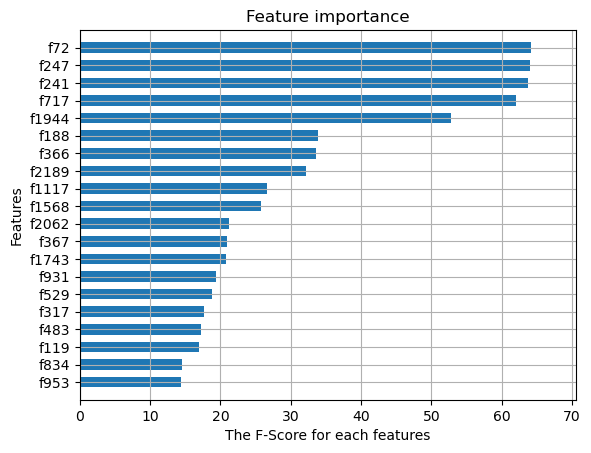

In [23]:
xgb.plot_importance(models[-1][1], height = 0.6, grid = True, importance_type = 'total_gain', show_values = False, max_num_features = 20)

plt.rcParams['figure.figsize'] = (10, 15)
plt.xlabel('The F-Score for each features')
plt.ylabel('Features')
plt.show()

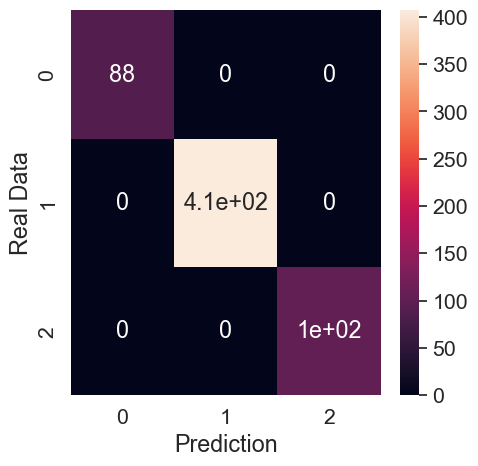

array([[ 88,   0,   0],
       [  0, 407,   0],
       [  0,   0, 103]], dtype=int64)

In [315]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 

model_predition_train = model.predict(x_train)

# sklearn에서 제공하는 confusion_matrix를 사용.
cm_train = confusion_matrix(y_train, model_predition_train)

# 출력 파트 - seaborn의 heatmap을 사용
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
 
ax = sns.heatmap(cm_train, annot=True)
plt.xlabel('Prediction')
plt.ylabel('Real Data')
plt.show()
cm_train

In [78]:
# date_df = train_df

# date_df['TIMESTAMP'] = pd.to_datetime(date_df['TIMESTAMP']).dt.strftime('%Y-%m-%d')
# date_df.head()

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='TIMESTAMP', ylabel='count'>

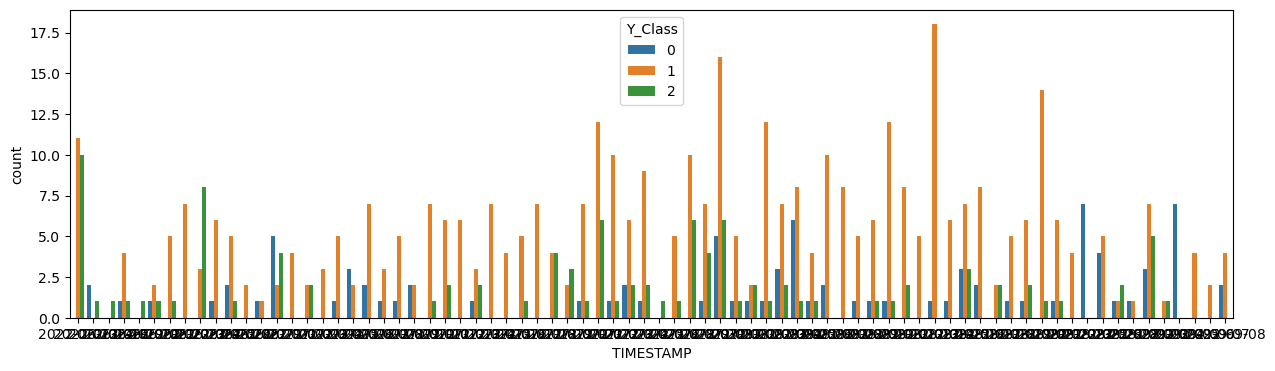

In [85]:
# plt.figure(figsize=(15,4))
# sns.countplot(data=date_df, x="TIMESTAMP", hue='Y_Class')
#날짜별로의 경향성은 없다.

In [103]:
# hour_df = train_df

# hour_df['TIMESTAMP'] = pd.to_datetime(hour_df['TIMESTAMP']).dt.strftime('%H')
# hour_df.head(10)

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,05,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,05,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,05,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,05,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,05,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN
5,TRAIN_005,2,0.537833,05,T050307,A_31,NaN,NaN,NaN,NaN,...,38.16,51.25,56.01,37.41,71.37,NaN,NaN,NaN,NaN,NaN
6,TRAIN_006,1,0.533665,06,T050304,A_31,NaN,NaN,NaN,NaN,...,32.50,41.42,38.36,30.83,76.93,NaN,NaN,NaN,NaN,NaN
7,TRAIN_007,2,0.540003,06,T050307,A_31,NaN,NaN,NaN,NaN,...,39.00,35.95,59.51,30.49,72.77,NaN,NaN,NaN,NaN,NaN
8,TRAIN_008,1,0.531821,06,T050304,A_31,NaN,NaN,NaN,NaN,...,42.25,43.17,55.60,33.26,78.50,NaN,NaN,NaN,NaN,NaN
9,TRAIN_009,2,0.538049,06,T050307,A_31,NaN,NaN,NaN,NaN,...,34.40,35.88,50.36,38.45,71.42,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='TIMESTAMP', ylabel='count'>

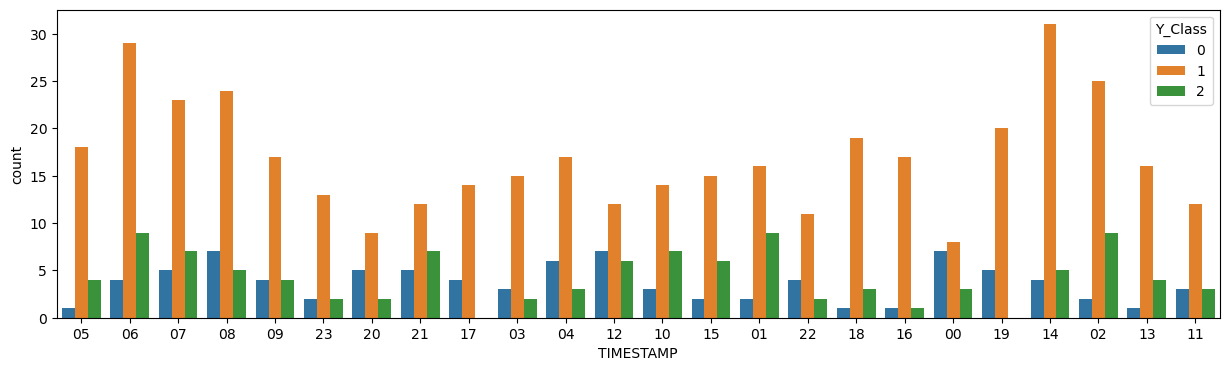

In [104]:
# plt.figure(figsize=(15,4))
# sns.countplot(data=hour_df, x="TIMESTAMP", hue='Y_Class')
# 시간에 따른 경향성도 크게 없다?